# 01 Data Exploration & Quality Check
### BDBA Capstone: Demographic Flows and Passive Equity Markets
**Author:** Antonio de Ipina  
**Date:** February 2026

This notebook loads, inspects, and validates all raw data inputs before they enter the simulation model. Each section maps to one of the five model modules.

## 0. Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to data folder
DATA_PATH = '..\data'

# Display settings
pd.set_option('display.max_columns', 15)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Setup complete.")

Setup complete.


## 1. Module 1: Demographics (Census Population Projections)
Source: U.S. Census Bureau, 2023 National Population Projections (NP2023_D1)  
Three scenarios: **mid** (main projection), **hi** (high immigration), **low** (low immigration)

Columns: SEX, ORIGIN, RACE, YEAR, TOTAL_POP, POP_0 through POP_100  
We filter to SEX=0 (both), ORIGIN=0 (total), RACE=0 (all races) to get total U.S. population by single year of age.

### 1.1 Load and inspect raw data

In [3]:
# Load all three scenarios
census_mid = pd.read_csv(f'{DATA_PATH}/census/np2023_d1_mid.csv')
census_hi = pd.read_csv(f'{DATA_PATH}/census/np2023_d1_hi.csv')
census_low = pd.read_csv(f'{DATA_PATH}/census/np2023_d1_low.csv')

print(f"Mid shape: {census_mid.shape}")
print(f"Hi shape:  {census_hi.shape}")
print(f"Low shape: {census_low.shape}")
print(f"\nColumns (first 10): {list(census_mid.columns[:10])}")
print(f"Columns (last 5):  {list(census_mid.columns[-5:])}")
census_mid.head(3)

Mid shape: (4332, 106)
Hi shape:  (4332, 106)
Low shape: (4332, 106)

Columns (first 10): ['SEX', 'ORIGIN', 'RACE', 'YEAR', 'TOTAL_POP', 'POP_0', 'POP_1', 'POP_2', 'POP_3', 'POP_4']
Columns (last 5):  ['POP_96', 'POP_97', 'POP_98', 'POP_99', 'POP_100']


,SEX,ORIGIN,RACE,YEAR,TOTAL_POP,POP_0,POP_1,...,POP_94,POP_95,POP_96,POP_97,POP_98,POP_99,POP_100
0,0,0,0,2022,333287557,3683113,3588817,...,248895,194667,145421,109622,78028,53870,88988
1,0,0,0,2023,334906305,3631327,3695123,...,253443,203141,155804,113960,83998,58334,96220
2,0,0,0,2024,336482168,3636897,3646544,...,267171,207018,162723,122212,87417,62906,101480


### 1.2 Filter to total population (both sexes, all races, all origins)

In [4]:
def filter_total_population(df, label):
    """Filter Census data to total population rows only."""
    filtered = df[(df['SEX'] == 0) & (df['ORIGIN'] == 0) & (df['RACE'] == 0)].copy()
    filtered = filtered.sort_values('YEAR').reset_index(drop=True)
    print(f"{label}: {len(filtered)} years, {filtered['YEAR'].min()} to {filtered['YEAR'].max()}")
    return filtered

mid = filter_total_population(census_mid, "Mid")
hi = filter_total_population(census_hi, "Hi")
low = filter_total_population(census_low, "Low")

Mid: 79 years, 2022 to 2100
Hi: 79 years, 2022 to 2100
Low: 79 years, 2022 to 2100


### 1.3 Sanity check total population over time
Verify that 2022 base year is ~330M and projections reach ~370-400M by 2060.

In [12]:
# Check 1: Does sum of age columns match TOTAL_POP?
age_cols = [f'POP_{i}' for i in range(101)]
mid['AGE_SUM'] = mid[age_cols].sum(axis=1)
mid['DIFF'] = mid['TOTAL_POP'] - mid['AGE_SUM']
print("Max discrepancy between TOTAL_POP and sum of age columns:", mid['DIFF'].abs().max())

# Check 2: Base year population (2022) should be ~330M+
base_pop = mid.loc[mid['YEAR'] == 2022, 'TOTAL_POP'].values[0]
print(f"\n2022 base population: {base_pop:,.0f}")

# Check 3: Scenario spread at key years
for year in [2025, 2035, 2045, 2050]:
    m = mid.loc[mid['YEAR'] == year, 'TOTAL_POP'].values[0] / 1e6
    h = hi.loc[hi['YEAR'] == year, 'TOTAL_POP'].values[0] / 1e6
    l = low.loc[low['YEAR'] == year, 'TOTAL_POP'].values[0] / 1e6
    print(f"{year}: Low {l:.1f}M | Mid {m:.1f}M | High {h:.1f}M | Spread: {h-l:.1f}M")

Max discrepancy between TOTAL_POP and sum of age columns: 0

2022 base population: 333,287,557
2025: Low 336.5M | Mid 338.0M | High 340.3M | Spread: 3.8M
2035: Low 344.0M | Mid 350.9M | High 361.2M | Spread: 17.2M
2045: Low 345.8M | Mid 358.4M | High 377.4M | Spread: 31.6M
2050: Low 345.0M | Mid 360.6M | High 384.1M | Spread: 39.0M


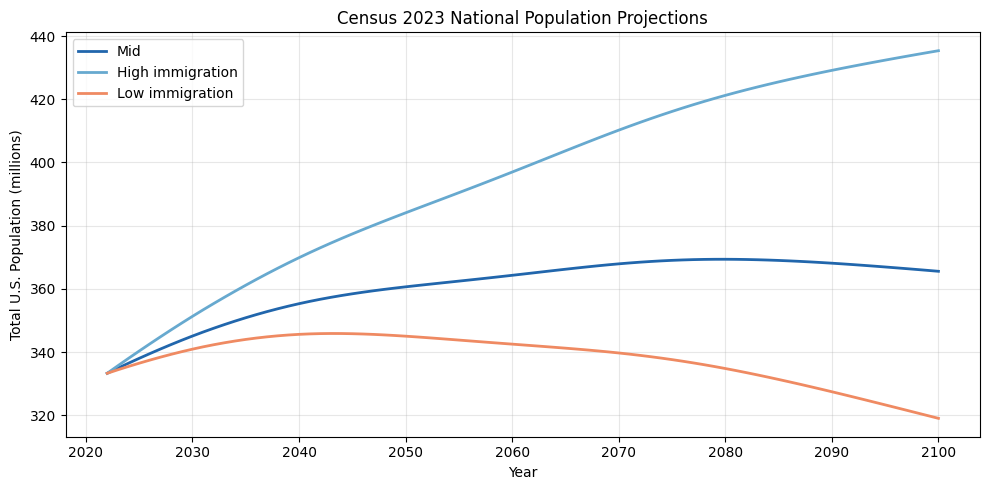

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

for df, label, color in [(mid, 'Mid', '#2166ac'), (hi, 'High immigration', '#67a9cf'), (low, 'Low immigration', '#ef8a62')]:
    ax.plot(df['YEAR'], df['TOTAL_POP'] / 1e6, label=label, color=color, linewidth=2)

ax.set_xlabel('Year')
ax.set_ylabel('Total U.S. Population (millions)')
ax.set_title('Census 2023 National Population Projections')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.4 Extract age cohort arrays for model period (2025–2050)
Build a matrix: rows = years, columns = single-year ages (0–100).  
This is the core demographic input for Modules 2 and 3.

In [6]:
# Age columns are POP_0 through POP_100
age_cols = [f'POP_{i}' for i in range(101)]

# Filter to model period
model_years = range(2025, 2051)

def extract_age_matrix(df, years):
    """Extract population-by-age matrix for specified years."""
    subset = df[df['YEAR'].isin(years)].set_index('YEAR')[age_cols]
    subset.columns = range(101)  # rename columns to integer ages
    return subset

pop_mid = extract_age_matrix(mid, model_years)
pop_hi = extract_age_matrix(hi, model_years)
pop_low = extract_age_matrix(low, model_years)

print(f"Age matrix shape: {pop_mid.shape}")
print(f"Years: {pop_mid.index.min()} to {pop_mid.index.max()}")
print(f"Ages: {pop_mid.columns.min()} to {pop_mid.columns.max()}")
pop_mid.head(3)

Age matrix shape: (26, 101)
Years: 2025 to 2050
Ages: 0 to 100


,0,1,2,3,4,5,6,...,94,95,96,97,98,99,100
YEAR,,,,,,,,,,,,,,,
2025,3641659,3652257,3661925,3720050,3627091,3730971,3779855,...,272160,218386,165976,127760,93846,65550,106523
2026,3646146,3657183,3667779,3676277,3731905,3639101,3742897,...,276566,222680,175226,130440,98205,70453,110819
2027,3650366,3661834,3672842,3682260,3689938,3743653,3650937,...,280589,226476,178861,137828,100371,73804,116676


### 1.5 Visualize key age groups relevant to the model
- **Working age (22–64):** Main contributors to 401(k) inflows (Module 2)
- **RMD age (73+/75+):** Mandatory withdrawal population (Module 3)
- **Peak cohort (1970–1973 births):** Hits RMD age 75 around 2045–2048

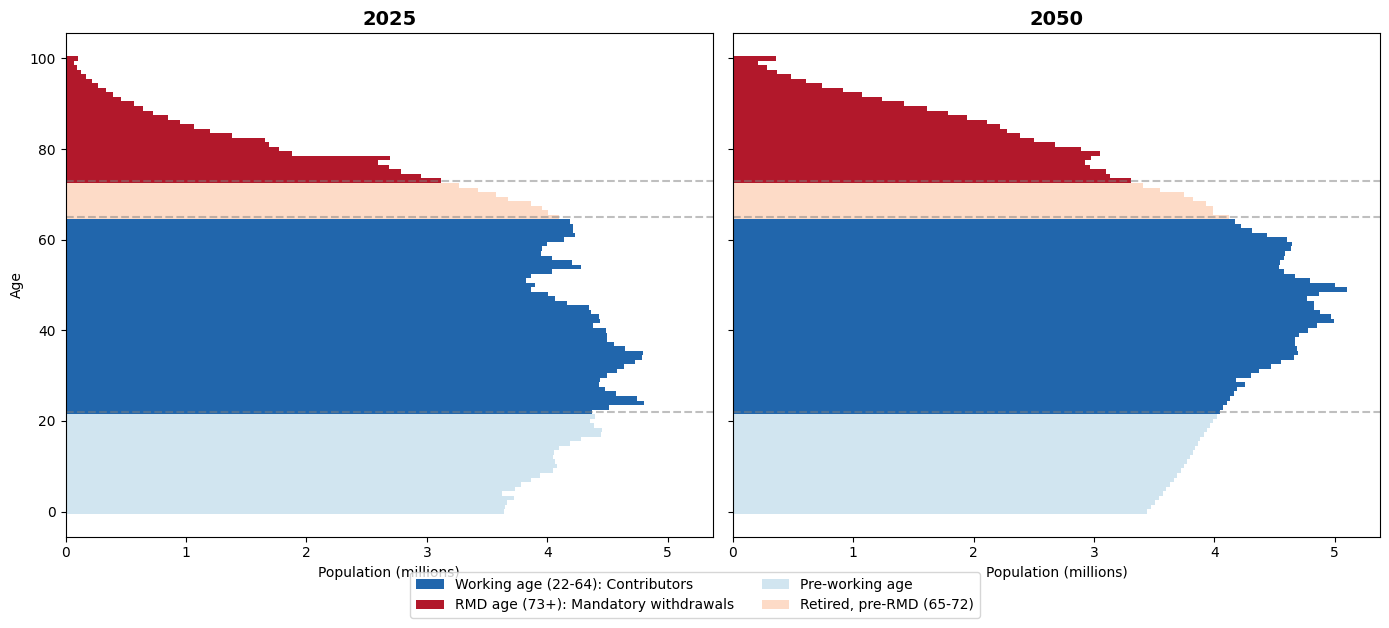

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, year, color in [(axes[0], 2025, '#2166ac'), (axes[1], 2050, '#b2182b')]:
    pop_data = pop_mid.loc[year] / 1e6
    
    # Color bars differently by life stage
    colors = []
    for age in range(101):
        if age < 22:
            colors.append('#d1e5f0')      # Pre-working
        elif age <= 64:
            colors.append('#2166ac')       # Working age (contributors)
        elif age <= 72:
            colors.append('#fddbc7')       # Retired, pre-RMD
        else:
            colors.append('#b2182b')       # RMD age
    
    ax.barh(range(101), pop_data, color=colors, height=1.0, edgecolor='none')
    ax.set_title(f'{year}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Population (millions)')
    ax.set_xlim(0, pop_mid.max().max() / 1e6 * 1.05)
    
    # Add life stage labels
    ax.axhline(y=22, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=65, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=73, color='gray', linestyle='--', alpha=0.5)

axes[0].set_ylabel('Age')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2166ac', label='Working age (22-64): Contributors'),
    Patch(facecolor='#b2182b', label='RMD age (73+): Mandatory withdrawals'),
    Patch(facecolor='#d1e5f0', label='Pre-working age'),
    Patch(facecolor='#fddbc7', label='Retired, pre-RMD (65-72)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

In [24]:
# Summary table: population by life stage
stages = {
    'Pre-working (0-21)': (0, 21),
    'Working age (22-64)': (22, 64),
    'Retired pre-RMD (65-72)': (65, 72),
    'RMD age (73+)': (73, 100)
}

print(f"{'Life Stage':<30} {'2025 (M)':>10} {'2050 (M)':>10} {'Change':>10}")
print("-" * 62)
for label, (age_lo, age_hi) in stages.items():
    pop_2025 = pop_mid.loc[2025, age_lo:age_hi].sum() / 1e6
    pop_2050 = pop_mid.loc[2050, age_lo:age_hi].sum() / 1e6
    pct_change = (pop_2050 / pop_2025 - 1) * 100
    print(f"{label:<30} {pop_2025:>10.1f} {pop_2050:>10.1f} {pct_change:>+9.1f}%")

Life Stage                       2025 (M)   2050 (M)     Change
--------------------------------------------------------------
Pre-working (0-21)                   88.5       82.4      -6.9%
Working age (22-64)                 186.2      196.1      +5.3%
Retired pre-RMD (65-72)              29.9       30.6      +2.3%
RMD age (73+)                        33.5       51.6     +54.2%


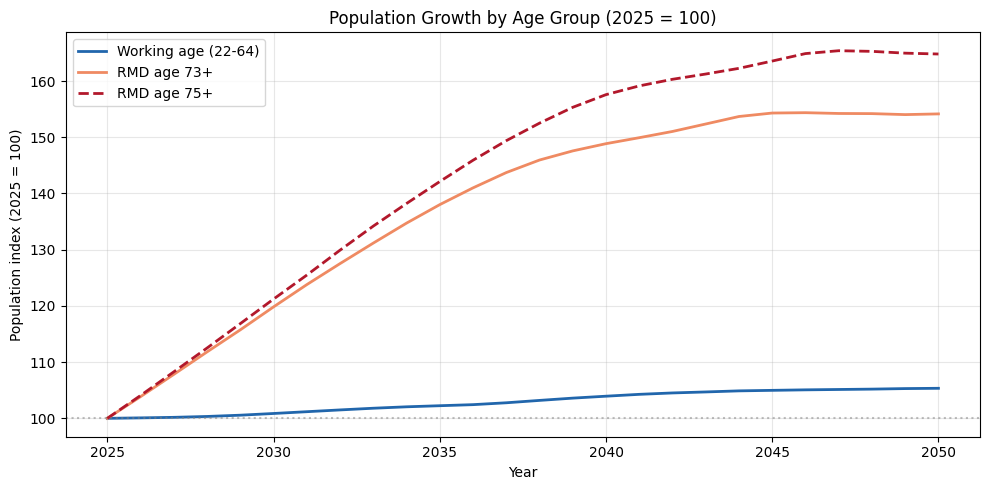

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

# Index to 2025 = 100
working_age_idx = working_age / working_age.loc[2025] * 100
rmd_73_idx = rmd_age_73 / rmd_age_73.loc[2025] * 100
rmd_75_idx = rmd_age_75 / rmd_age_75.loc[2025] * 100

ax.plot(pop_mid.index, working_age_idx, label='Working age (22-64)', color='#2166ac', linewidth=2)
ax.plot(pop_mid.index, rmd_73_idx, label='RMD age 73+', color='#ef8a62', linewidth=2)
ax.plot(pop_mid.index, rmd_75_idx, label='RMD age 75+', color='#b2182b', linewidth=2, linestyle='--')
ax.axhline(y=100, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Population index (2025 = 100)')
ax.set_title('Population Growth by Age Group (2025 = 100)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.7 Ratio check: RMD-age population as share of working-age population
This ratio captures the demographic pressure building in the system as it rises, outflows grow relative to inflows (According to the Hypothesis).

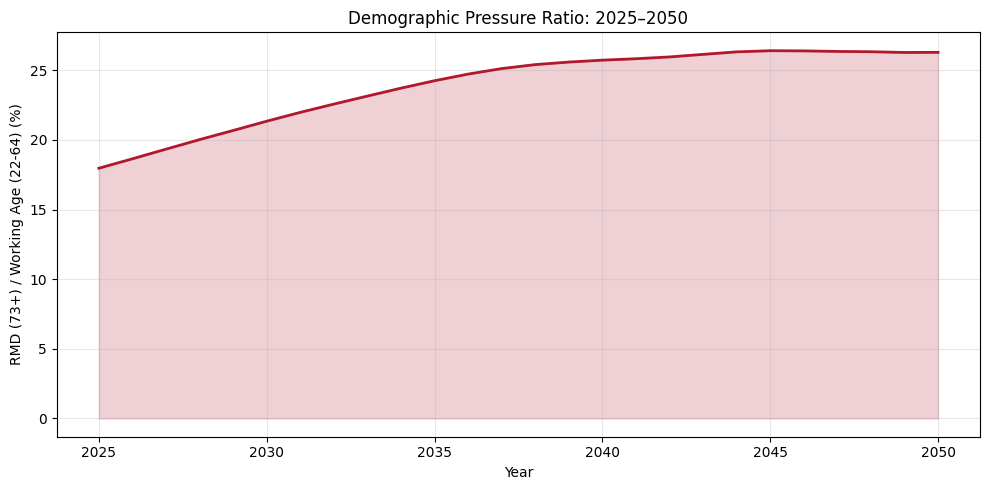

2025: 18.0%
2035: 24.3%
2045: 26.4%
2050: 26.3%


In [9]:
ratio = rmd_age_73 / working_age * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pop_mid.index, ratio, color='#b2182b', linewidth=2)
ax.fill_between(pop_mid.index, ratio, alpha=0.2, color='#b2182b')
ax.set_xlabel('Year')
ax.set_ylabel('RMD (73+) / Working Age (22-64) (%)')
ax.set_title('Demographic Pressure Ratio: 2025–2050')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"2025: {ratio.loc[2025]:.1f}%")
print(f"2035: {ratio.loc[2035]:.1f}%")
print(f"2045: {ratio.loc[2045]:.1f}%")
print(f"2050: {ratio.loc[2050]:.1f}%")

### 1.8 Save processed demographic data for Module 2 & 3
Export the cleaned age matrices so the model notebook can load them directly without re-filtering.

In [10]:
# Save processed age matrices
output_path = '../data/processed'
os.makedirs(output_path, exist_ok=True)

pop_mid.to_csv(f'{output_path}/pop_age_matrix_mid.csv')
pop_hi.to_csv(f'{output_path}/pop_age_matrix_hi.csv')
pop_low.to_csv(f'{output_path}/pop_age_matrix_low.csv')

print(f"Saved 3 age matrices to {output_path}/")
print(f"Each matrix: {pop_mid.shape[0]} years × {pop_mid.shape[1]} ages")

Saved 3 age matrices to ../data/processed/
Each matrix: 26 years × 101 ages
